In [126]:
import requests
from bs4 import BeautifulSoup
import re
import json
from tqdm import tqdm_notebook as tqdm
import psycopg2  
from peewee import *
from playhouse.postgres_ext import PostgresqlExtDatabase, JSONField, ArrayField
from playhouse.shortcuts import model_to_dict


In [31]:
db.rollback()

In [196]:
bdname='sinesearch_db'
bduser = 'postgres'
bdpassword = 'nef441'
bdhost = '51.79.69.179'
bdport = 5432

db = PostgresqlExtDatabase(bdname, user=bduser, password=bdpassword,
                           host=bdhost, port=bdport)

In [197]:
from peewee import *
from playhouse.postgres_ext import PostgresqlExtDatabase, JSONField, ArrayField
        
class Users(Model):
    user_id=IntegerField(index=True,null=False)
    age=IntegerField(default=20)
    sex=IntegerField(default=0)

    ganres=ArrayField(FloatField,default=[])
    group=IntegerField(default=-1)
    mark_wight=FloatField(default=0)
    just_marked = IntegerField(default=1)

    liked=ArrayField(IntegerField,default=[])
    viewed=ArrayField(IntegerField,default=[])
    disliked=ArrayField(IntegerField,default=[])
    
    disliked_vector=ArrayField(FloatField,default=[])
    liked_vector=ArrayField(FloatField,default=[])

    predict_films=ArrayField(IntegerField,default=[])

    class Meta:
        database = db
        db_table='Users_fp'

class Films(Model):
    film_id=IntegerField(unique=True,index=True)
    stars = FloatField(default=0)
    level=IntegerField(default=0,null=True)
    year=IntegerField(default=2000)
    vector=ArrayField(FloatField,default=[])

    ganres=ArrayField(FloatField,default=[])
    meanage=FloatField(default=20)
    sex=FloatField(default=0.5)

    likes=IntegerField(default=10)
    dislikes=IntegerField(default=10)
    shit=IntegerField(default=0)
    marks=IntegerField(default=0)

    errors=IntegerField(default=0)
    opening=IntegerField(default=0)
    count_triler=IntegerField(default=0)

    class Meta:
        database = db
        db_table='Films_fp'

In [47]:
count=Users.select().count()

In [48]:
from playhouse.shortcuts import model_to_dict
users = []
for i in tqdm(range(0,count,100)):
    usrs=Users.select().offset(i).limit(100).execute()
    for u in usrs:
        users.append(model_to_dict(u))

In [129]:
def user_preparation(data):
    data=data.copy()
    
    del data["group"]
    del data["just_marked"]
    del data["predict_films"]
    del data["user_id"]
    del data["id"]

    
    msex=0
    mage=0
    myers=0
    liked_films=Films.select().where(Films.film_id.in_(data["liked"]+data["viewed"])).execute()
    for f in liked_films:
        msex+=f.sex
        mage+=f.meanage
        myers+=2019 - f.year
        
    data["myers"]=myers/(len(liked_films)+1)
    data["mage"]=mage/(len(liked_films)+1)
    data["msex"]=msex/(len(liked_films)+1)
    


    del data["viewed"]
    del data["disliked"]
    del data["liked"]
    
    vb = data["ganres"]+data["liked_vector"]
    del data["ganres"]
    del data["liked_vector"]
    del data["disliked_vector"]
    
    res = list(OrderedDict(data).values())+vb    
    return res
        

In [130]:
dataset=[]
for u in tqdm(users):
    dataset.append(user_preparation(u))    

In [131]:
with open("users_dataset","w") as f:
    json.dump(dataset,f)

In [133]:
from sklearn.preprocessing import normalize
dataset=normalize(dataset)

In [135]:
import pandas as pd
import numpy as np
df_train=dataset

In [136]:
from sklearn.cluster import KMeans

# Описываем модель
model = KMeans(n_clusters=10)

# Проводим моделирование
model.fit(df_train)

# Предсказание на всем наборе данных
all_predictions = model.predict(df_train)

# Выводим предсказания
print(all_predictions)

[2 8 4 2 2 4 2 0 0 0 8 6 2 2 8 2 6 5 5 0 8 8 4 0 9 2 6 6 0 3 3 0 3 0 2 0 5
 5 5 1 2 5 2 5 5 0 4 2 5 5 5 4 7 7 2 7 2 0 4 0 5 4 9 9 5 0 5 5 8 3 5 7 6 6
 0 4 5 4 6 8 2 5 8 4 5 6 4 8 2 6 6 9 5 5 9 7 5 0 5 5 2 3 4 7 5 5 8 4 0 1 2
 8 8 2 9 1 5]


In [147]:
def get_group(user):
    from sklearn.cluster import AffinityPropagation
    import numpy as np
    import pickle
    with open('clustering', 'rb') as f:
        clustering = pickle.load(f)

    ujson = model_to_dict(user)
    data = user_preparation(ujson)

    return clustering.predict([data])[0]

In [168]:
from sklearn.cluster import AffinityPropagation
import numpy as np


clustering = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False).fit(df_train)
# clustering.labels_

clustering.predict(df_train[0:10])
# array([0, 1])
# clustering.cluster_centers_


array([0, 5, 5, 8, 0, 5, 0, 7, 7, 7], dtype=int64)

In [150]:
import pickle
pickle.dump(clustering, open("clustering", "wb"))

In [141]:
clustering.predict(df_train)

array([0, 5, 5, 8, 0, 5, 0, 7, 7, 7, 8, 1, 0, 0, 8, 0, 1, 2, 2, 7, 5, 5,
       8, 7, 6, 0, 1, 1, 7, 3, 3, 7, 3, 7, 8, 7, 6, 2, 5, 6, 0, 5, 0, 5,
       5, 7, 5, 0, 2, 5, 2, 5, 4, 4, 0, 4, 0, 7, 5, 7, 5, 5, 6, 6, 2, 7,
       2, 2, 5, 3, 2, 4, 1, 1, 7, 5, 2, 0, 1, 5, 0, 2, 8, 5, 2, 1, 8, 5,
       8, 1, 1, 6, 2, 2, 6, 4, 2, 7, 2, 2, 0, 3, 8, 4, 2, 2, 8, 8, 7, 2,
       0, 8, 5, 0, 6, 2, 2], dtype=int64)

In [153]:
for u in tqdm(Users.select().execute()):
    u.group=get_group(u)
    u.save()

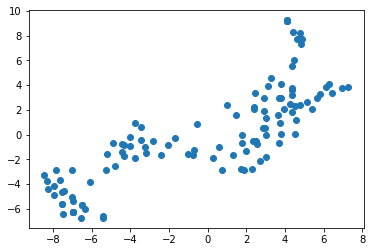

In [160]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Определяем модель и скорость обучения
model = TSNE(learning_rate=1)

# Обучаем модель
transformed = model.fit_transform(df_train)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
# plt.show()

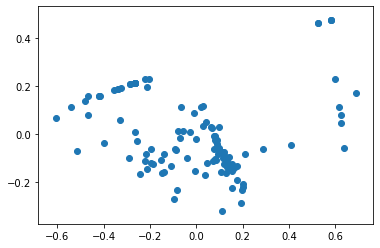

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [161]:
# Импортируем библиотеки
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


# Определяем модель
dbscan = DBSCAN(eps = 5)

# Обучаем
dbscan.fit(df_train)

# Уменьшаем размерность при помощи метода главных компонент
pca = PCA(n_components=20).fit(df_train)
transformed = pca.transform(df_train)

x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis)
plt.show()

dbscan.fit_predict(df_train)

In [195]:
np.random.choice([1,2,3,4,5],5,replace=False).tolist()

[2, 3, 5, 1, 4]

In [202]:
Users.select().count()

117